In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


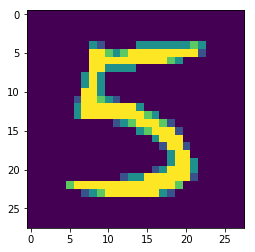

In [3]:
plt.imshow(mnist.train.images[1200, :].reshape(28, 28))

In [4]:
learning_rate = 0.001
epochs = 2000
batch_size = 100
display_step = 100
n_input = 784
n_classes = 10

In [24]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    X = tf.placeholder(shape=[None, n_input], dtype=tf.float32)
    y = tf.placeholder(shape=[None, n_classes], dtype=tf.float32)
    keep_prob = tf.placeholder(dtype=tf.float32)
    def conv2d(x, W, b, strides=1):
        # strides: NHWC 长度为 4 的列表： [batch, height, width, channel]
        x = tf.nn.conv2d(input=x, filter=W, strides=[1, strides, strides, 1], padding="SAME")
        x = tf.nn.bias_add(x, b)
        return tf.nn.relu(x)
    
    def maxpool2d(x, size=2, strides=2):
        ksize = [1, size, size, 1]
        strides = [1, strides, strides, 1]
        return tf.nn.max_pool(value=x, ksize=ksize, strides=strides, padding="SAME")
    
    def conv_net(x, weights, biases, keep_prob):
        # weights, biases are dic
        x_image = tf.reshape(x, shape=[-1, 28, 28, 1])
        
        # conv layer 1 -> [-1, 28, 28, 1]
        conv1 = conv2d(x_image, W=weights["wc1"], b=biases["bc1"], strides=1)
        # max_pooling 1 -> [-1, 14, 14, 32]
        pool1 = maxpool2d(conv1, size=2, strides=2)
        
        # conv layer 2 -> [-1, 14, 14, 64]
        conv2 = conv2d(pool1, W=weights["wc2"], b=biases["bc2"], strides=1)
        #max_pooling 2 -> [-1, 7, 7, 64]
        pool2 = maxpool2d(conv2, size=2, strides=2)
        
        # FC [-1, 7 * 7 * 64] -> [-1, 1024]
        x_image = tf.reshape(pool2, shape=[-1, weights["wd1"].shape[0]])
        fc1 = tf.nn.relu(x_image @ weights["wd1"] + biases["bd1"])
        
        # Dropout:
        fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob)
        
        # ouput: [-1, 1024] -> [-1，10]
        out = fc1_drop @ weights["out"] + biases["out"]
        return out
        
    weights = {
    "wc1": tf.Variable(tf.random_normal(shape=[5, 5, 1, 32])),
    "wc2": tf.Variable(tf.random_normal(shape=[5, 5, 32, 64])),
    "wd1": tf.Variable(tf.random_normal(shape=[7 * 7 * 64, 1024])),
    "out": tf.Variable(tf.random_normal(shape=[1024, n_classes]))
    }

    biases = {
        "bc1": tf.Variable(tf.random_normal(shape=[32])),
        "bc2": tf.Variable(tf.random_normal(shape=[64])),
        "bd1": tf.Variable(tf.random_normal(shape=[1024])),
        "out": tf.Variable(tf.random_normal(shape=[n_classes]))
    }
    y_pred = conv_net(X, weights, biases, keep_prob=keep_prob)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y))
    train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)        
    acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pred, axis=1))
                         ,dtype=tf.float32))
    
        

In [23]:
with tf.Session(graph=g) as sess:
    test_holder = {X: mnist.test.images[:1000, :], y: mnist.test.labels[:1000, :], keep_prob: 1.0}
    sess.run(tf.global_variables_initializer())
    for epoch_id in range(epochs):
        batch_X, batch_y = mnist.train.next_batch(batch_size)
        sess.run(train_step, feed_dict={X: batch_X, y: batch_y, keep_prob: 0.75})
        if epoch_id % display_step == 0:
            train_cost = sess.run(cross_entropy, feed_dict={X: batch_X, y: batch_y, keep_prob: 0.75})
            test_acc = sess.run(acc, feed_dict=test_holder)
            print("epoch %d, test_acc: %.4f, train_cost: %.4f" % (epoch_id, test_acc, train_cost))

epoch 0, test_acc: 0.1310, train_cost: 71519.0312
epoch 100, test_acc: 0.8630, train_cost: 4384.2124
epoch 200, test_acc: 0.9030, train_cost: 1743.4038
epoch 300, test_acc: 0.9180, train_cost: 1473.3047
epoch 400, test_acc: 0.9360, train_cost: 472.7553
epoch 500, test_acc: 0.9450, train_cost: 974.2297
epoch 600, test_acc: 0.9490, train_cost: 111.5532
epoch 700, test_acc: 0.9490, train_cost: 564.0584
epoch 800, test_acc: 0.9540, train_cost: 346.1654
epoch 900, test_acc: 0.9570, train_cost: 665.4534
epoch 1000, test_acc: 0.9620, train_cost: 566.0750
epoch 1100, test_acc: 0.9620, train_cost: 541.2032
epoch 1200, test_acc: 0.9610, train_cost: 326.1720
epoch 1300, test_acc: 0.9590, train_cost: 261.0021
epoch 1400, test_acc: 0.9600, train_cost: 330.7505
epoch 1500, test_acc: 0.9630, train_cost: 163.5055
epoch 1600, test_acc: 0.9620, train_cost: 317.1008
epoch 1700, test_acc: 0.9610, train_cost: 144.0731
epoch 1800, test_acc: 0.9650, train_cost: 141.3055
epoch 1900, test_acc: 0.9650, train_co